# Mental Health in Tech Project

## Data Sets

[OSMI Survey on Mental Health in the Tech Workplace in 2014](https://www.kaggle.com/osmi/mental-health-in-tech-survey) 

["Ongoing" OSMI survey from 2016](https://data.world/kittybot/osmi-mental-health-tech-2016)


## Questions

What factors are most signficant in influencing whether or not a person believes disclosing a mental health issue would have negative consequences?

Can we predict, based on publicly available features of a person and company, whether that person is likely to beleive disclosing a mental health issue would be harmful for their career?

## Plan

In [1]:
# clean 2014 data:
#   - remove invalid ages  ( < 16, > 80)
#   - create gender categories
#   - create dictionary to map questions to column names (from original data set)
#   - add year column with all 2014s

In [2]:
# use only US data

In [3]:
# plot number of responses by age

In [4]:
# plot frequency of mental health consequences yes/no/maybe by age

In [5]:
# plot frequency of mental health consequence yes/no/maybe by age groups (quantiles, 4-6 groups)

In [6]:
################ Logistic Regression

In [7]:
# logistic regression 
# - combine mental health consequences (yes and maybe) vs no as boolean categorical Y to predict
# - pull out X variables that are public
# - created dummies for categorical public X variables

## Setup
<hr>


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# some plotting colors:
y = badass = '#BADA55'
m = '#444444'
n = 'b'
coffee = '#C0FFEE'

## Import & Initial Data Cleaning: 2014
<hr>

In [9]:
df14 = pd.read_csv("./datasets/2014/mental-health-in-tech-2014.csv")
print df14.shape
# df14.head(3)

(1259, 27)


### Column Names & Corresponding Questions

In [10]:
# standardize columns to have lowercase names
df14.rename(columns={'Age': 'age', 'Gender': 'gender', 'Country': 'country', 'Timestamp': 'timestamp'}, inplace=True)
# replace no_employees column name
df14.rename(columns={'no_employees': 'num_employees'}, inplace=True)
df14.head(3)

,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,num_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN


In [11]:
df_original = pd.read_csv("./datasets/2014/osmi-mental-health-in-tech-original.csv")
# print df_original.columns   # original questions/fields

<details><summary> Click to expand all **original questions/fields** from 2014 </summary>
    
- Timestamp   
- Age  
- Gender   
- Country  
- If you live in the United States, which state or territory do you live in?  
- Are you self-employed?  
- Do you have a family history of mental illness?  
- Have you sought treatment for a mental health condition?  
- If you have a mental health condition, do you feel that it interferes with your work?  
- How many employees does your company or organization have?  
- Do you work remotely (outside of an office) at least 50% of the time?  
- Is your employer primarily a tech company/organization?  
- Does your employer provide mental health benefits?  
- Do you know the options for mental health care your employer provides?  
- Has your employer ever discussed mental health as part of an employee wellness program?  
- Does your employer provide resources to learn more about mental health issues and how to seek help?  
- Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?  
- How easy is it for you to take medical leave for a mental health condition?  
- Do you think that discussing a mental health issue with your employer would have negative consequences?  
- Do you think that discussing a physical health issue with your employer would have negative consequences?  
- Would you be willing to discuss a mental health issue with your coworkers?  
- Would you be willing to discuss a mental health issue with your direct supervisor(s)?  
- Would you bring up a mental health issue with a potential employer in an interview?  
- Would you bring up a physical health issue with a potential employer in an interview?  
- Do you feel that your employer takes mental health as seriously as physical health?  
- Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?  
- Any additional notes or comments
</details>

In [12]:
# create reference to look up questions based on column names
column_names = df14.columns
questions = df_original.columns
cq14 = { 
    column_names[i]: questions[i] for i in range(df_original.shape[1]-1) 
}

# for example:
cq14['mental_vs_physical']

'Do you feel that your employer takes mental health as seriously as physical health?'

In [13]:
df14.cq = cq14

### Invalid and Missing Data

In [14]:
# helper function to preview a column
def preview_col(col, data, index_order=None):
    if col in data.cq:
        print data.cq[col]
    counts = data[col].value_counts(dropna=False)
    percents = counts * (100.0/data.shape[0])
    df = pd.concat([counts, percents], axis=1)
    df.columns = ['count', 'percent']
    if (index_order != None):
        df = df.reindex(index_order)
    return df

#### NaN check

In [15]:
def print_nan_counts(data):
    counts = data.count()
    numrows = data.shape[0]
    for col in data.columns:
        if counts[col] != numrows:
            print "{0} has {1} NaNs".format(col, numrows-counts[col])

In [16]:
print_nan_counts(df14)

state has 515 NaNs
self_employed has 18 NaNs
work_interfere has 264 NaNs
comments has 1095 NaNs


In [17]:
df14.dropna(subset=['self_employed'], inplace=True) 

#### Timestamps

Timestamps are time series data. The survey actually spans about 1.5 years, from August 2014 to February 2016.  The vast majority (89.9%) of the survey submissions were collected during August 27-29, 2015. Not really used in this analysis.

In [18]:
df14['timestamp'] = df14['timestamp'].map(pd.to_datetime)

In [19]:
first = df14.timestamp.min()
print first
last = df14.timestamp.max()
print last

2014-08-27 11:34:53
2016-02-01 23:04:31


In [20]:
aug14 = df14[(df14['timestamp'].dt.year==2014)]
aug14 = aug14[(aug14['timestamp'].dt.month==8)]
submit_date_counts = aug14['timestamp'].groupby(aug14['timestamp'].dt.day).count()
float(submit_date_counts.sum()) / df14.shape[0]

0.9000805801772764

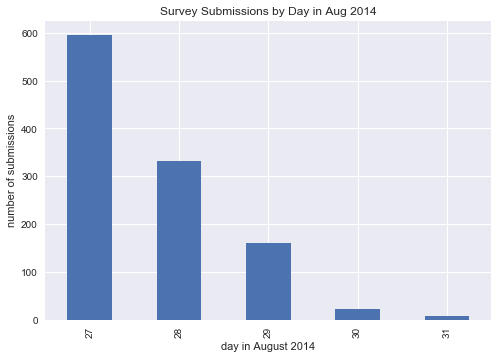

In [21]:
p = submit_date_counts.plot(kind='bar', title='Survey Submissions by Day in Aug 2014')
p.set_xlabel('day in August 2014')
p.set_ylabel('number of submissions')

#### Invalid Ages

This is supposed to be a survey of working adults, so values under 16 and over 80 can be ignored.

In [22]:
def nan_invalid_ages(data, agemin=16, agemax=80):
    data.age = data.age.map(lambda x: np.nan if (x<agemin or x>agemax) else x)

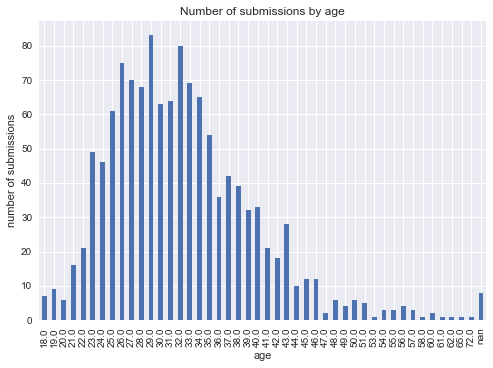

In [23]:
nan_invalid_ages(df14)
p = df14['age'].value_counts(dropna=False).sort_index().plot(kind='bar')
p.set_title('Number of submissions by age')
p.set_xlabel('age')
p.set_ylabel('number of submissions')

In [24]:
# df14[np.isnan(df14['age'])]
df14.dropna(subset=['age'], inplace=True) 

#### Gender responses

Gender responses are strings entered by the user. To create a more manageable set of variables, I examine all the gender responses and categorize them into `female`, `male`, or `other`. Trans men and women map to `male` and `female` categories, respectively. 

In [25]:
# print df14.gender.unique()

In [26]:
# categorize gender responses into male, female, other based on response
def categorize_gender(gender_response):
    if type(gender_response) != str:
        return 'other'
    gender_response = gender_response.strip().lower()
    
    male_category_responses = {
        'cis male', 'cis man', 'cisdude', 'dude',
        "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take?",
        'm', 'mail', 'maile', 'make', 'mal', 'male', 'male (cis)', 'male (trans)',
        'male (trans, ftm)', 'male.', 'malr', 'man', 'msle', 'm|'
    }
    
    
    female_category_responses = {
        'cis female', 'cis-female/femme', 'cis-woman', 'cisgender female', 'f', 'fem',
        'femail', 'femake', 'female', 'female (cis)', 'female assigned at birth', 
        'female (props for making this a freeform field, though)', 'female (trans)',
        'female/woman', 'fm', 'i identify as female.', 'mtf', 'trans woman', 
        'trans-female', 'transgender woman', 'transitioned, m2f', 'woman'
    }
    
    if gender_response in male_category_responses:
        return 'male'
    elif gender_response in female_category_responses:
        return 'female'
    else:
        # print gender_response
        return 'other'

<details><summary> click to see `gender_response` values mapped to `other` for 2014:</summary>
    - male-ish  
    - something kinda male?  
    - queer/she/they  
    - non-binary  
    - nah  
    - all  
    - enby  
    - fluid  
    - genderqueer  
    - androgyne  
    - agender  
    - guy (-ish) ^_^  
    - male leaning androgynous  
    - neuter  
    - queer  
    - a little about you  
    - p  
    - ostensibly male, unsure what that really means
</details>

In [27]:
df14['gender_category'] = df14.gender.map(categorize_gender)

        count    percent
male      972  78.832117
female    246  19.951338
other      15   1.216545


/Users/bgveenstra/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


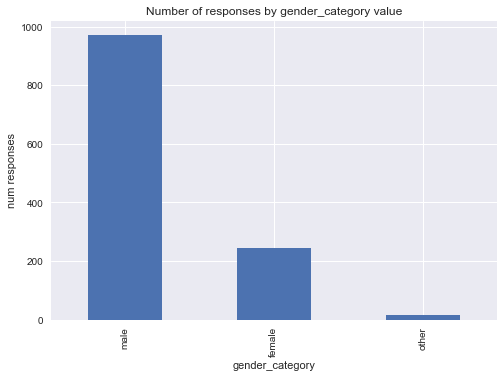

In [28]:
s = preview_col('gender_category', df14)
print s

def countplot(summary, col, colors=None):
    p = summary['count'].plot(kind='bar', colors=colors) 
    p.set_title('Number of responses by {0} value'.format(col))
    p.set_xlabel(col)
    p.set_ylabel('num responses')
    
def percentplot(summary, col, colors=None):
    p = summary['percent'].plot(kind='bar', colors=colors) 
    p.set_title('Percent of responses by {0} value'.format(col))
    p.set_xlabel(col)
    p.set_ylabel('percent of responses')
    
countplot(s, 'gender_category')

### Yes/no questions

Many of the survey questions are yes/no questions, but the data is currently stored as strings. Convert these to `1` for `Yes` and `0` for `No`.

In [29]:
# change one response from yes/no to 1/0 (or keep response if it's an other)
def yes_no_same(response):
    if response=='Yes' or response==1:
        return 1
    elif response=='No' or response==0:
        return 0
    else:
        return response

In [30]:
# change all yes/no responses in a column to 1/0
def yes_no_same_column(data, column_name):
    data[column_name] = data[column_name].map(yes_no_same)

In [31]:
two_opt_cols = [col for col in df14.columns if len(df14[col].unique())==2]
for col in two_opt_cols:
    print col, df14[col].unique()

self_employed ['Yes' 'No']
family_history ['Yes' 'No']
treatment ['No' 'Yes']
remote_work ['Yes' 'No']
tech_company ['Yes' 'No']
obs_consequence ['Yes' 'No']


In [32]:
for col in two_opt_cols:
    yes_no_same_column(df14, col)
#     print '\n', col+':', preview_col(col, df14)

### Other Categorical Columns

Many of the survey questions have yes/no/maybe or other meaningful third choices. 

There are also categorical columns for state, country, number of employees, how easy it is to take medical leave, and whether a condition interferes with work.

In [33]:
def get_prefix(response):
    if type(response) != str:
        return response
    else:
        return response.lower().replace("'", "").replace(" ", "_")

#### Three-option columns

In [34]:
three_opt_cols = [col for col in df14.columns if len(df14[col].unique()) == 3]
for col in three_opt_cols:
    print col, df14[col].unique()

benefits ['Yes' 'No' "Don't know"]
care_options ['Not sure' 'No' 'Yes']
wellness_program ['Yes' 'No' "Don't know"]
seek_help ["Don't know" 'No' 'Yes']
anonymity ['Yes' 'No' "Don't know"]
mental_health_consequence ['No' 'Maybe' 'Yes']
phys_health_consequence ['No' 'Maybe' 'Yes']
coworkers ['Yes' 'Some of them' 'No']
supervisor ['Yes' 'Some of them' 'No']
mental_health_interview ['No' 'Maybe' 'Yes']
phys_health_interview ['Yes' 'Maybe' 'No']
mental_vs_physical ['Yes' "Don't know" 'No']
gender_category ['male' 'female' 'other']


In [35]:
for col in three_opt_cols:
    df14[col] = df14[col].map(get_prefix)
#     print col, df14[col].unique()

#### Country & State

Country


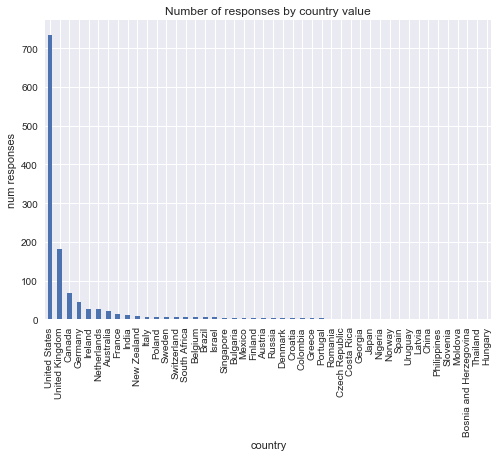

In [36]:
# print df14['country'].unique()
s = preview_col('country', df14)
# print s
countplot(s, 'country')
countries = df14['country'].map(get_prefix)

In [37]:
# dummy_dfs['country'] = pd.get_dummies(countries)

If you live in the United States, which state or territory do you live in?


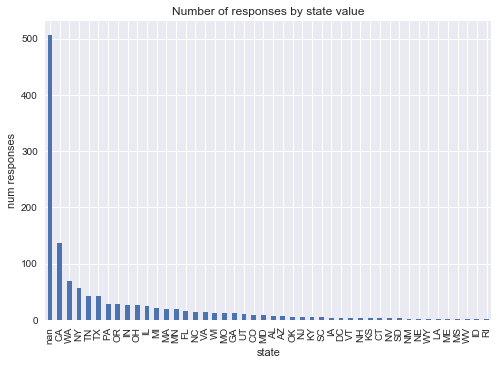

In [38]:
# print df14['state'].unique()
s = preview_col('state', df14)
# print s
countplot(s, 'state')

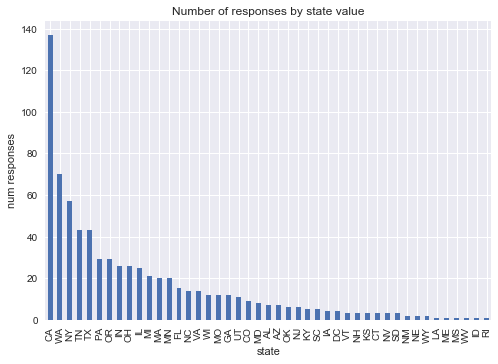

In [39]:
uss = s.drop(np.nan)
countplot(uss, 'state')

In [40]:
# dummy_dfs['state'] = pd.get_dummies(df14.state, prefix='state', dummy_na=True)

#### How many employees does your company or organization have?

How many employees does your company or organization have?
          count    percent
1-5         156  12.652068
6-25        283  22.952149
26-100      283  22.952149
100-500     172  13.949716
500-1000     59   4.785077
1000+       280  22.708840


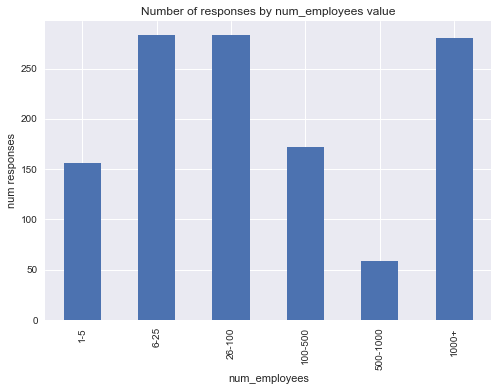

In [41]:
df14.num_employees = df14.num_employees.map(lambda x: '1000+' if x=='More than 1000' else x)
s = preview_col('num_employees', df14, 
            index_order=['1-5', '6-25', '26-100', '100-500', '500-1000', '1000+'])
print s

countplot(s, 'num_employees')

#### How easy is it for you to take medical leave for a mental health condition?

How easy is it for you to take medical leave for a mental health condition?
                    count    percent
very_difficult         96   7.785888
somewhat_difficult    121   9.813463
somewhat_easy         262  21.248986
very_easy             202  16.382806
dont_know             552  44.768856


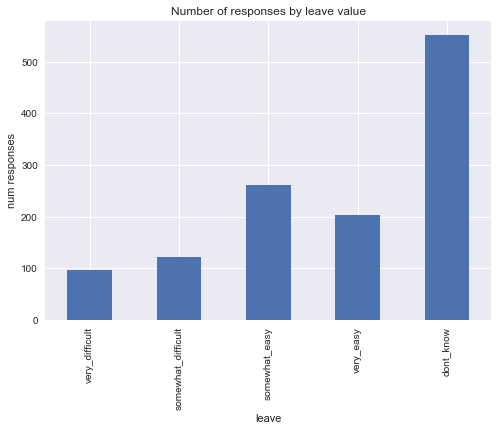

In [42]:
df14['leave'] = df14['leave'].map(get_prefix)
s = preview_col('leave', df14, 
                index_order=['very_difficult', 'somewhat_difficult', 
                             'somewhat_easy', 'very_easy', 'dont_know'
                            ]
               )
print s
countplot(s, 'leave')

#### If you have a mental health condition, do you feel that it interferes with your work?

If you have a mental health condition, do you feel that it interferes with your work?
           count    percent
never        206  16.707218
rarely       170  13.787510
sometimes    457  37.064071
often        138  11.192214
NaN          262  21.248986


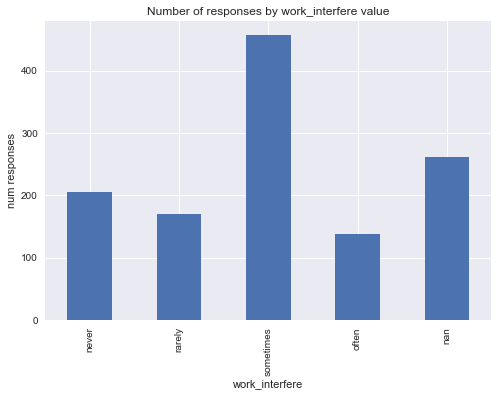

In [43]:
df14['work_interfere'] = df14['work_interfere'].map(get_prefix)
s = preview_col('work_interfere', df14, 
                index_order=['never', 'rarely', 'sometimes', 'often', np.nan]
               )
print s
countplot(s, 'work_interfere')

In [44]:
def prefix_preview_countplot(col, data, index_order=None):
    print col
    data[col] = data[col].map(get_prefix)
    s = preview_col(col, data, 
                    index_order=index_order
                   )
    print s
    countplot(s, col)

work_interfere
If you have a mental health condition, do you feel that it interferes with your work?
           count    percent
never        206  16.707218
rarely       170  13.787510
sometimes    457  37.064071
often        138  11.192214
NaN          262  21.248986


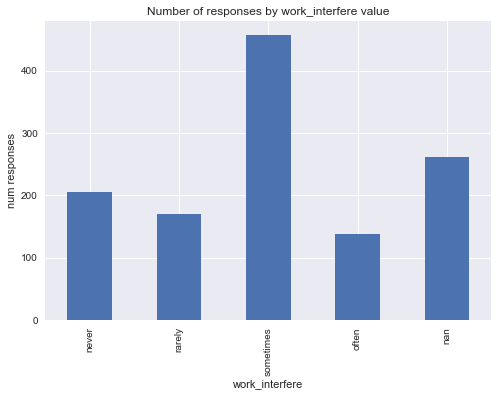

In [45]:
prefix_preview_countplot('work_interfere', df14, 
                index_order=['never', 'rarely', 'sometimes', 'often', np.nan]
               )

## Checkpoint: Export, Import

In [46]:
df14['year']=2014
df14.to_csv(path_or_buf="./datasets/2014/clean-no-dummies-2014.csv")

In [47]:
df14 = pd.read_csv('./datasets/2014/clean-no-dummies-2014.csv', index_col=0)
df14.cq = cq14

## Other Codings for Categorical Variables

### Dummy Variables 2014

In [48]:
# create dictionary to organize dummy data frames throughout
ddfs14 = {} # dummy dataframes, 2014
df14.dummy_dict = ddfs14

In [49]:
ddfs14['gender_category'] = pd.get_dummies(df14['gender_category'], prefix='gender_category')
ddfs14['gender_category'].head(3)

,gender_category_female,gender_category_male,gender_category_other
18,0,1,0
19,0,1,0
20,0,1,0


In [50]:
def dummy_head(col, data, dummy_data_dict, use_na=False, prefix=None):
    if (prefix == None):
        prefix=col
    dummy_data_dict[col] = pd.get_dummies(data[col], prefix=prefix, dummy_na=use_na)
    return dummy_data_dict[col].head(3)
    
dummy_head('state', df14, ddfs14, use_na=True)

,state_AL,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_IA,state_ID,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,state_nan
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
dummy_head('country', df14, ddfs14, use_na=True)

,country_Australia,country_Austria,country_Belgium,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_China,country_Colombia,country_Costa Rica,...,country_Slovenia,country_South Africa,country_Spain,country_Sweden,country_Switzerland,country_Thailand,country_United Kingdom,country_United States,country_Uruguay,country_nan
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [52]:
dummy_head('work_interfere', df14, ddfs14, use_na=True)

,work_interfere_never,work_interfere_often,work_interfere_rarely,work_interfere_sometimes,work_interfere_nan
18,0,0,0,1,0
19,0,0,0,0,1
20,0,0,0,1,0


In [53]:
dummy_head('num_employees', df14, ddfs14)

,num_employees_1-5,num_employees_100-500,num_employees_1000+,num_employees_26-100,num_employees_500-1000,num_employees_6-25
18,1,0,0,0,0,0
19,0,0,0,0,0,1
20,0,1,0,0,0,0


In [54]:
dummy_head('leave', df14, ddfs14)

,leave_dont_know,leave_somewhat_difficult,leave_somewhat_easy,leave_very_difficult,leave_very_easy
18,0,0,0,0,1
19,0,0,1,0,0
20,0,1,0,0,0


In [55]:
print three_opt_cols
for col in three_opt_cols:
    dummy_head(col, df14, ddfs14)

['benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'gender_category']


In [56]:
ddfs14.keys()

['phys_health_interview',
 'care_options',
 'mental_vs_physical',
 'benefits',
 'wellness_program',
 'num_employees',
 'country',
 'seek_help',
 'work_interfere',
 'leave',
 'state',
 'gender_category',
 'coworkers',
 'mental_health_consequence',
 'anonymity',
 'supervisor',
 'mental_health_interview',
 'phys_health_consequence']

In [57]:
df = pd.concat(ddfs14.values(), axis=1)
df.head(3)

,phys_health_interview_maybe,phys_health_interview_no,phys_health_interview_yes,care_options_no,care_options_not_sure,care_options_yes,mental_vs_physical_dont_know,mental_vs_physical_no,mental_vs_physical_yes,benefits_dont_know,...,anonymity_yes,supervisor_no,supervisor_some_of_them,supervisor_yes,mental_health_interview_maybe,mental_health_interview_no,mental_health_interview_yes,phys_health_consequence_maybe,phys_health_consequence_no,phys_health_consequence_yes
18,0,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0
19,1,0,0,1,0,0,1,0,0,0,...,1,0,1,0,1,0,0,0,1,0
20,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0


### Numerical Categories 2014

In [58]:
# categorical variables 
catvars = ddfs14.keys()
catvars

['phys_health_interview',
 'care_options',
 'mental_vs_physical',
 'benefits',
 'wellness_program',
 'num_employees',
 'country',
 'seek_help',
 'work_interfere',
 'leave',
 'state',
 'gender_category',
 'coworkers',
 'mental_health_consequence',
 'anonymity',
 'supervisor',
 'mental_health_interview',
 'phys_health_consequence']

In [59]:
catnum14 = {}
df14.catnum = catnum14

In [60]:
for col in catvars:
    u = df14[col].unique()
    catnum14[col] = { i: u[i] for i in range(len(u)) }
    df14[col+'_category_num'] = df14[col].map(lambda x: u.tolist().index(x))

In [61]:
# catnum14.keys()
# df14.columns.sort_values()

In [62]:
print catnum14['care_options']

{0: 'not_sure', 1: 'no', 2: 'yes'}


In [63]:
def translate_num(col, num, data=df14):
    return data.catnum[col][num]

translate_num('country', 18)

'South Africa'

## Model

In [64]:
mhc = 'mental_health_consequence'
mhcnum = 'mental_health_consequence_category_num'
nmy = ['no', 'maybe', 'yes']

### Initial Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier

Do you think that discussing a mental health issue with your employer would have negative consequences?
       count    percent
no       476  38.605028
maybe    471  38.199513
yes      286  23.195458


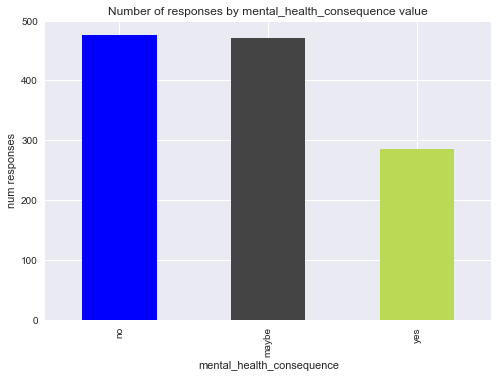

In [66]:
s = preview_col(mhc, df14, index_order=nmy)
print s
countplot(s, mhc, colors=[n,m,y])

In [67]:
total_y = df14[mhcnum].copy()
print df14.catnum[mhc]
total_y.head(3)

{0: 'no', 1: 'maybe', 2: 'yes'}


18    0
19    0
20    1
Name: mental_health_consequence_category_num, dtype: int64

In [68]:
employer_cols = ['self_employed', 'tech_company', 'num_employees_category_num', 'country_category_num',]
person_cols = [ 'gender_category_category_num', 'age']
private_cols = ['treatment', 'family_history', 'obs_consequence']
X_cols = employer_cols+person_cols+private_cols

In [69]:
df14.columns
total_X = df14[X_cols].copy()
total_X.head(3)

,self_employed,tech_company,num_employees_category_num,country_category_num,gender_category_category_num,age,treatment,family_history,obs_consequence
18,1,1,0,0,0,46.0,0,1,1
19,1,1,1,1,0,36.0,0,1,0
20,0,1,2,0,0,29.0,1,1,0


In [70]:
model = RandomForestClassifier(n_estimators = 20)
    
model.fit(total_X, total_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

                       Features  Importance Score
5                           age          0.481996
3          country_category_num          0.156814
2    num_employees_category_num          0.152303
4  gender_category_category_num          0.043271
7                family_history          0.041724
1                  tech_company          0.036073
6                     treatment          0.032582
8               obs_consequence          0.032153
0                 self_employed          0.023085


(0, 1)

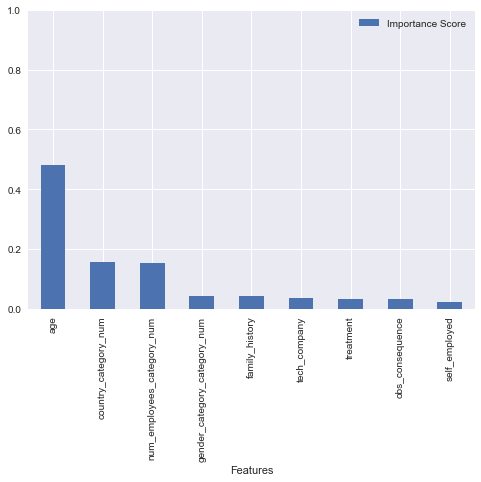

In [71]:
features = total_X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

print features_df
f = features_df.plot(kind='bar', x='Features')
f.set_ylim(0,1)

### Mental Health Consequences Boolean Column

Adding a column that will have 1 if the respondent answered `yes` or `maybe` for mental health consequence, and 0 if `no`.

Do you think that discussing a mental health issue with your employer would have negative consequences?


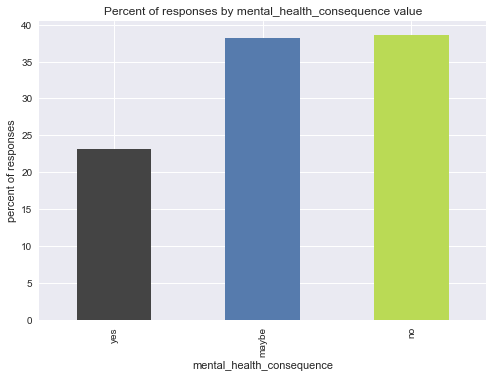

In [72]:
badass = '#BADA55'
grey = '#444444'
red = '#ff3300'
bluegrey = '#34598B'
yellow = '#ffbb00'
orange = '#ff7700'
blue = '#567BAD'
m = blue
y = grey
eh = bluegrey
n = badass

ymn=['yes', 'maybe', 'no']

mhc = 'mental_health_consequence'
mhcp = preview_col(mhc, df14, index_order=ymn)
percentplot(mhcp, mhc, colors=[y,m,n])

In [73]:
# from multiclass mental health consequence column, get a boolean column
mhc2 = 'mental_health_yes_maybe'

In [74]:
def ymn_response(ynmstr):
    if ynmstr == 'no':
        return 0
    else:
        return 1
df14['mental_health_yes_maybe'] = df14['mental_health_consequence'].map(lambda(x): ymn_response(x))

In [75]:
df14[mhc2].value_counts(dropna=False)

1    757
0    476
Name: mental_health_yes_maybe, dtype: int64

### Limit to United States

Focus on the US to avoid legal differences among countries. 

In [76]:
usdf14 = df14[df14['country']=='United States'].copy()
usdf14.cq = df14.cq
usdf14.shape

(735, 48)

In [77]:
total_y = usdf14[mhcnum].copy()
print df14.catnum[mhc]
total_y.head(3)

{0: 'no', 1: 'maybe', 2: 'yes'}


18    0
20    1
21    0
Name: mental_health_consequence_category_num, dtype: int64

In [78]:
total_X = usdf14[X_cols].copy()
total_X.head(3)

,self_employed,tech_company,num_employees_category_num,country_category_num,gender_category_category_num,age,treatment,family_history,obs_consequence
18,1,1,0,0,0,46.0,0,1,1
20,0,1,2,0,0,29.0,1,1,0
21,1,1,0,0,0,31.0,0,0,0


In [79]:
usm = RandomForestClassifier(n_estimators = 20)
    
usm.fit(total_X, total_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

                       Features  Importance Score
5                           age          0.606019
2    num_employees_category_num          0.170970
7                family_history          0.049348
6                     treatment          0.042937
4  gender_category_category_num          0.041081
1                  tech_company          0.040495
8               obs_consequence          0.028500
0                 self_employed          0.020651
3          country_category_num          0.000000


(0, 1)

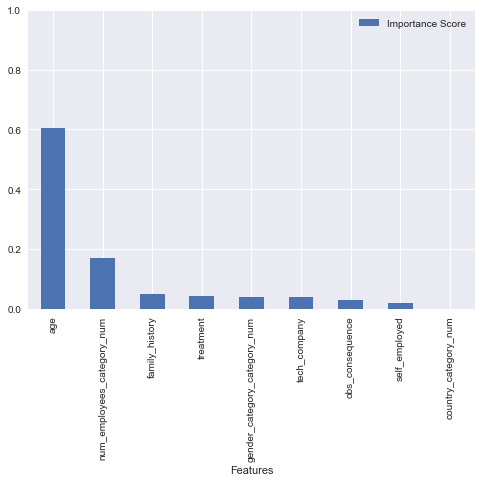

In [80]:
features = total_X.columns
feature_importances = usm.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

print features_df
f = features_df.plot(kind='bar', x='Features')
f.set_ylim(0,1)

All Countries
   count    percent
1    757  61.394972
0    476  38.605028


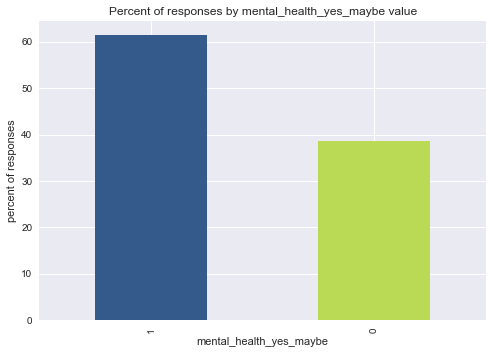

In [81]:
s = preview_col(mhc2, df14)
print 'All Countries'
print s

percentplot(s, mhc2, colors=[eh, n])

United States only
   count    percent
1    464  63.129252
0    271  36.870748


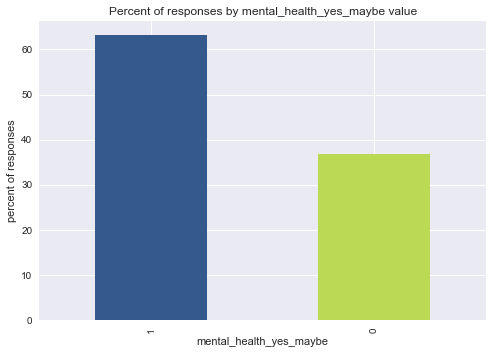

In [82]:
s = preview_col(mhc2, usdf14)

print 'United States only'
print s

percentplot(s, mhc2, colors=[eh, n])

### Investigate age

In [83]:
# Total data

# sns.boxplot(x=mhc, y='age', data=df14)
# df14.groupby(mhc)['age'].describe()

mental_health_consequence       
maybe                      count    295.000000
                           mean      33.383051
                           std        7.898961
                           min       19.000000
                           25%       28.000000
                           50%       32.000000
                           75%       38.000000
                           max       72.000000
no                         count    271.000000
                           mean      32.501845
                           std        7.605005
                           min       18.000000
                           25%       27.000000
                           50%       32.000000
                           75%       36.000000
                           max       60.000000
yes                        count    169.000000
                           mean      33.532544
                           std        7.372758
                           min       18.000000
                           

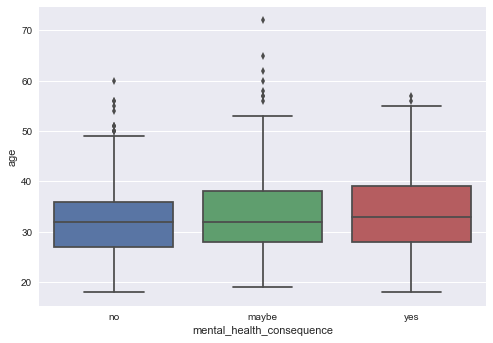

In [84]:
# US only

sns.boxplot(x=mhc, y='age', data=usdf14)
usdf14.groupby(mhc)['age'].describe()

In [85]:
# for r in usdf14[mhc].unique():
#     usdf14[usdf14[mhc]==r]['age'].plot.hist(alpha=0.30, label=r, legend=True, bins=15)

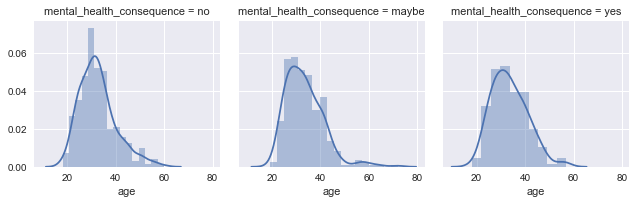

In [86]:
g = sns.FacetGrid(usdf14, col=mhc)  
g.map(sns.distplot, 'age')  

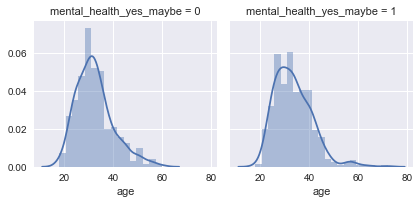

In [87]:
g = sns.FacetGrid(usdf14, col=mhc2)  
g.map(sns.distplot, 'age')  

In [88]:
# sns.swarmplot(y=mhc, x='age', data=usdf14)

In [89]:
# group by main (col name), and get dataframe 
# with proportion (percentage) of values for sub (col name)
def cat_proportion_in_col(df, main, sub):
    d = df[[main, sub]].copy()
    count_subs_per_main = d.groupby([main, sub]).size()
    percent_subs_per_main = count_subs_per_main.groupby(level=[0]).apply(lambda x: 100*x /  x.sum())
    pdf = pd.DataFrame(percent_subs_per_main)
    pdf.reset_index(inplace=True)
    pdf.rename(columns={0:'percentage'}, inplace=True)
    return pdf

In [94]:

grouped = cat_proportion_in_col(usdf14, mhc2, 'age')
# # group who believe there is cause for worry or concern 
wdf = grouped[grouped[mhc2]==1][['age', 'percentage']]

# # no conern group (disclosing diagnosis is safe)
nwdf = grouped[grouped[mhc2]==0][['age', 'percentage']]



In [95]:
# perform t-test on 2-dimensional data in the 2 groups 
# not working as I intend; giving 2 separate metrics
from scipy.stats import ttest_ind

print ttest_ind(wdf, nwdf)

Ttest_indResult(statistic=array([ 1.21143941, -0.53409381]), pvalue=array([ 0.22948037,  0.5948355 ]))


### Proportions of Responses

In [96]:
cat_proportion_in_col(df14, 'treatment', mhc)

,treatment,mental_health_consequence,percentage
0,0,maybe,36.557377
1,0,no,44.098361
2,0,yes,19.344262
3,1,maybe,39.807384
4,1,no,33.226324
5,1,yes,26.966292


In [97]:
def factorplot_percentage(df, main_col, sub_col):
    percent_df = cat_proportion_in_col(df, main_col, sub_col)
    print percent_df
    fg = sns.factorplot(
        x=mhc, 
        y='percentage',
        col=main_col,
        data=percent_df, 
        kind='bar',
        palette='Set1',
        order=['no', 'maybe', 'yes']
    )
    fg.set_xlabels('')
    fg.fig.subplots_adjust(top=0.84)
    fg.fig.suptitle('{0} response proportions by {1}'.format(sub_col, main_col))

   treatment mental_health_consequence  percentage
0          0                     maybe   38.023952
1          0                        no   44.311377
2          0                       yes   17.664671
3          1                     maybe   41.895262
4          1                        no   30.673317
5          1                       yes   27.431421


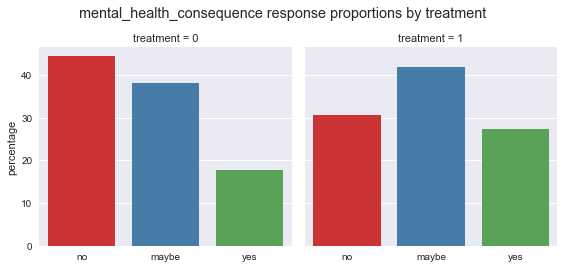

In [98]:
factorplot_percentage(usdf14, 'treatment', mhc)

   obs_consequence mental_health_consequence  percentage
0                0                     maybe   40.586420
1                0                        no   39.043210
2                0                       yes   20.370370
3                1                     maybe   36.781609
4                1                        no   20.689655
5                1                       yes   42.528736


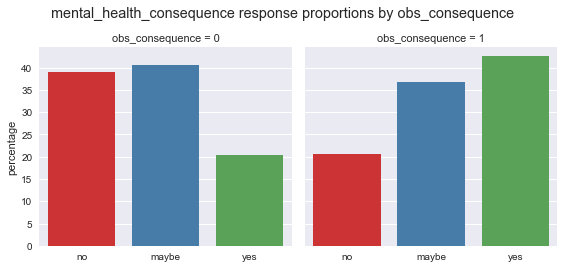

In [99]:
factorplot_percentage(usdf14, 'obs_consequence', mhc)

   tech_company mental_health_consequence  percentage
0             0                     maybe   47.445255
1             0                        no   25.547445
2             0                       yes   27.007299
3             1                     maybe   38.461538
4             1                        no   39.464883
5             1                       yes   22.073579


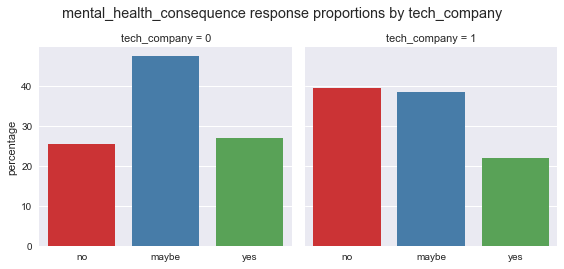

In [100]:
factorplot_percentage(usdf14,  'tech_company', mhc)

  gender_category mental_health_consequence  percentage
0          female                     maybe   44.692737
1          female                        no   27.374302
2          female                       yes   27.932961
3            male                     maybe   38.475499
4            male                        no   40.290381
5            male                       yes   21.234120
6           other                     maybe   60.000000
7           other                       yes   40.000000


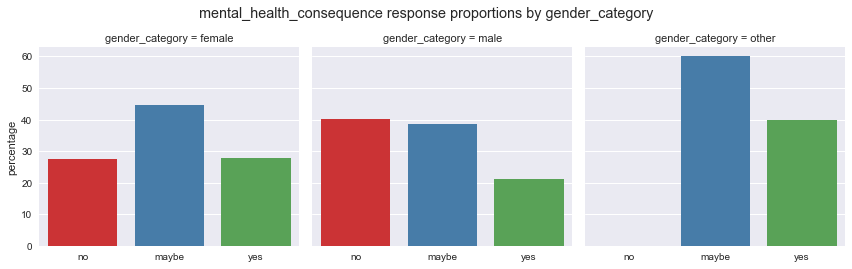

In [101]:
factorplot_percentage(usdf14,  'gender_category', mhc)

   work_interfere mental_health_consequence  percentage
0           never                     maybe   42.622951
1           never                        no   40.163934
2           never                       yes   17.213115
3           often                     maybe   37.974684
4           often                        no   25.316456
5           often                       yes   36.708861
6          rarely                     maybe   40.366972
7          rarely                        no   41.284404
8          rarely                       yes   18.348624
9       sometimes                     maybe   41.696113
10      sometimes                        no   29.328622
11      sometimes                       yes   28.975265


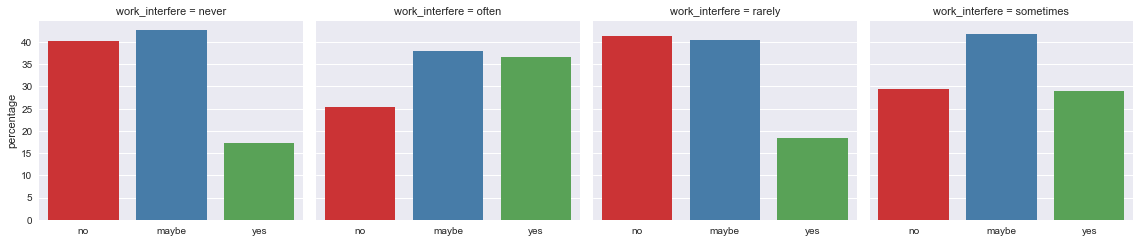

In [102]:
wi_df = cat_proportion_in_col(usdf14, 'work_interfere', mhc)
print wi_df
fg = sns.factorplot(
    x=mhc, 
    y='percentage',
    col='work_interfere',
    data=wi_df, 
    kind='bar',
    palette='Set1',
    order=['no', 'maybe', 'yes']
)
fg.set_xlabels('')
fg.fig.subplots_adjust(top=0.84)
# fg.fig.suptitle('{0} response proportions by {1}'.format(mhc, 'work_interfere'))

In [119]:
# age counts
agec = df14['age'].value_counts()
agec = agec.sort_index()

In [123]:
# number of mhc2 "yes/maybe" responses for each age
agey = df14.groupby('age')[mhc2].sum()
# agey[3:30,]

In [124]:
# percent of 'maybe/yes' mental health consequences responses, for responses between age 21 and 47
agep = 100.0 * agey[3:30,]/agec[3:30,]

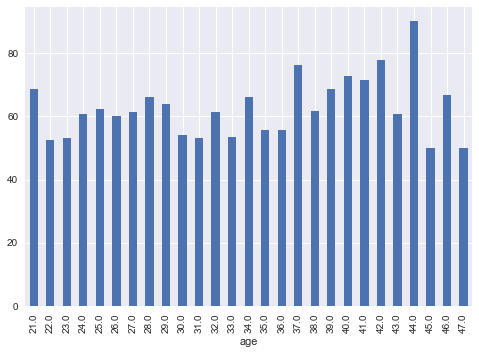

In [125]:
agep.plot(kind='bar')

In [144]:
# nr = usdf14.shape[0]
# quintiles = [int(nr*.2*i) for i in range(1, 6)]

In [164]:
std = usdf14['age'].std()
med = usdf14['age'].median()
down15 = med - 1.5*std
up15 = med + 1.5*std
print down15, up15

20.4865707544 43.5134292456


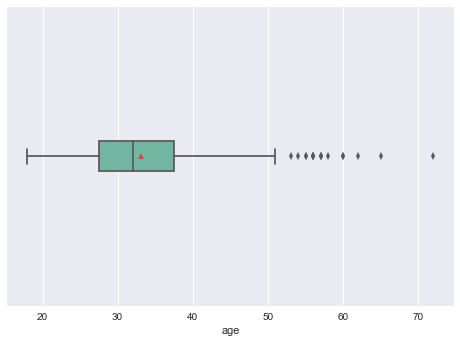

In [146]:
sns.boxplot( y='age', data=usdf14, showmeans=True, width=0.1, palette='Set2', orient='h')

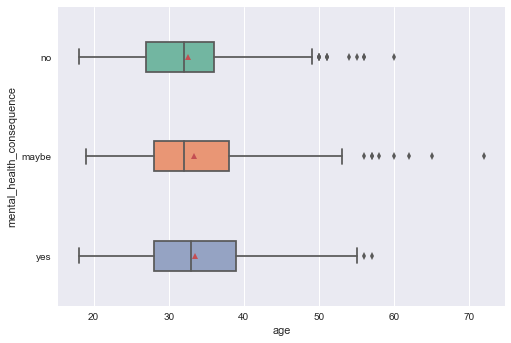

In [157]:

sns.boxplot(x='age', y=mhc, data=usdf14, showmeans=True, palette='Set2', orient='h', width=0.3)


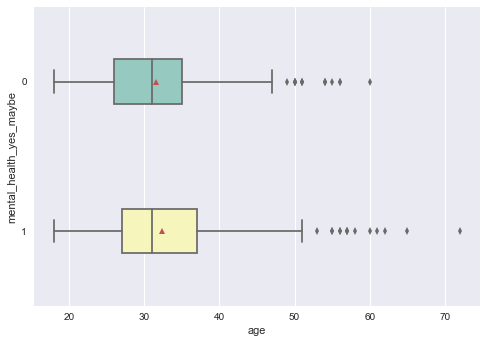

In [159]:

sns.boxplot(y=mhc2, x='age', data=df14, palette='Set3', width=0.3, showmeans=True, orient='h');

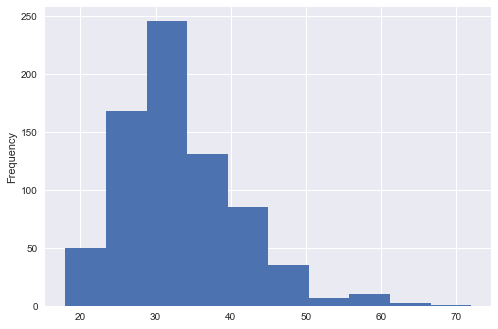

In [161]:

usdf14['age'].plot.hist()

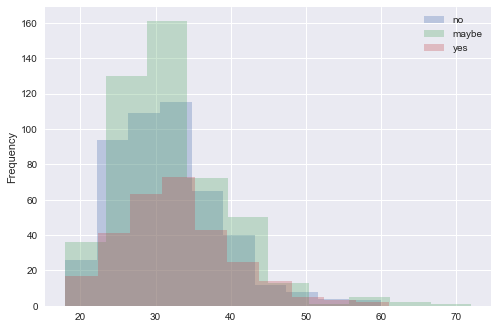

In [116]:
for r in df14[mhc].unique():
    df14[df14[mhc]==r]['age'].plot.hist(alpha=0.30, label=r, legend=True)

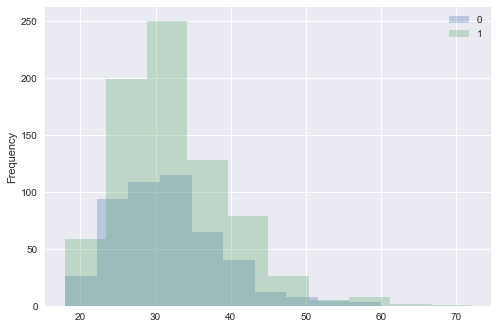

In [117]:
for r in df14[mhc2].unique():
    df14[df14[mhc2]==r]['age'].plot.hist(alpha=0.30, label=r, legend=True)

In [118]:
import statsmodels.stats.weightstats as sm
from scipy.stats import ttest_ind

mhc21age = df14[df14[mhc2]==1]['age'].dropna()
mhc20age = df14[df14[mhc2]==0]['age'].dropna()

# t-test, p-value, degrees of freedom
print sm.ttest_ind(mhc21age, mhc20age)


# print ttest_ind(mhc21age, mhc20age)

(1.9426878882307723, 0.052281658104509313, 1231.0)


In [ ]:
nd = df14[df14[mhc]=='no']['age'].dropna()
yd = df14[df14[mhc]=='yes']['age'].dropna()
md = df14[df14[mhc]=='maybe']['age'].dropna()

print sm.ttest_ind(nd, yd)
print sm.ttest_ind(nd, md)
print sm.ttest_ind(md, yd)

In [ ]:
gc = 'gender_category'
fc = df14[df14[gc]=='female'][mhc2].dropna()
mc = df14[df14[gc]=='male'][mhc2].dropna()
oc = df14[df14[gc]=='other'][mhc2].dropna()


print sm.ttest_ind(fc, mc)
print sm.ttest_ind(fc, oc)
print sm.ttest_ind(oc, mc)


In [ ]:
for r in df14[gc].unique():
    df14[df14[gc]==r][mhc2].plot.hist(alpha=0.30, label=r, legend=True)

In [ ]:
obc = 'obs_consequence'
obc1 = df14[df14[obc]==1][mhc2].dropna()
obc0 = df14[df14[obc]==0][mhc2].dropna()
print sm.ttest_ind(obc1, obc0)
for r in df14[obc].unique():
    df14[df14[obc]==r][mhc2].plot.hist(alpha=0.30, label=r, legend=True)

In [ ]:
def onetwothree(x):
    if x=='yes':
        return 2
    elif x=='maybe':
        return 1
    else:
        return 0

df = df14.copy().dropna()
df['mhcnum'] = df[mhc].map(onetwothree)
df['mhcnum']


obc12 = df[df[obc]==1]['mhcnum'].dropna()
obc02 = df[df[obc]==0]['mhcnum'].dropna()
print sm.ttest_ind(obc12, obc02)

In [ ]:
dms = []
for col in df14.columns:
    l = len(df14[col].unique())
    if l == 2:
#         print col
        if 0 in df14[col].unique():
            dms.append(col)
        else:
            print col

dms.remove(mhc+'_maybe')
dms.remove(mhc+'_no')
dms.remove(mhc+'_yes')
dms.remove(mhc2)
states = ['state_AL', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_FL', 'state_GA', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_NC', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 'state_nan']         
states.remove('state_CA')            

seekhelp = ['seek_help_dont_know', 'seek_help_no', 'seek_help_yes']
seekhelp.remove('seek_help_no')

careopts = [ 'care_options_no', 'care_options_not_sure', 'care_options_yes']
careopts.remove('care_options_no')
interfere = ['work_interfere_never', 'work_interfere_often', 'work_interfere_rarely', 'work_interfere_sometimes', 'work_interfere_nan']
interfere.remove('work_interfere_never')

In [ ]:
xcols = ['treatment'] + ['obs_consequence']  + seekhelp +  careopts #+ states 
X = df14[xcols]

In [ ]:
X.head(3)

In [ ]:
import statsmodels.discrete.discrete_model as discrete_model
y = df14[mhc2]

logit = discrete_model.Logit(y, X, missing='drop')
result = logit.fit()
result.summary()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
# from sklearn.metrics import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.7, stratify=y)

In [ ]:

lr = LogisticRegression()
lrm = lr.fit(trainX, trainY)
print 'Intercept: \n', lr.intercept_
print 'Coefficients: \n', lr.coef_
probs = lr.predict_proba(testX)
# print 'Logreg predicted probabilities: \n',probs[:5,]
print 'Score: \n', lr.score(testX, testY)

In [ ]:
pred = lr.predict(testX)
pred

In [ ]:
cm = confusion_matrix(testY, pred)
                 # predicted mhc2==0   # predicted mhc2==1
# actual mhc2==0     12                   71
# actual mhc2==1      8                   133
cm

In [ ]:
print 'false pos / pos pred: ', float(cm[0][1])/(cm[1][1] + cm[0][1])
print 'true pos / pos pred: ', float(cm[1][1])/(cm[1][1] + cm[0][1])
print 'true pos / actual pos: ', float(cm[1][1])/(cm[1][1] + cm[1][0])
# high false positive rate

In [ ]:
# roc_curve(testY, probs[:,1])

In [ ]:
roc_auc_score(testY,probs[:,1])

In [ ]:
def roc_auc( X, train_fraction=0.7):
#     print 'Columns: \n', X.columns.tolist()
    trainX, testX, trainY, testY = train_test_split(X, y, train_size=train_fraction, stratify=y)
    lr = LogisticRegression()
    lrm = lr.fit(trainX, trainY)
#     print 'Intercept: \n', lr.intercept_
#     print 'Coefficients: \n', lr.coef_
    probs = lr.predict_proba(testX)
    print 'Model Internal Score: \n', lr.score(testX, testY)
    pred = lr.predict(testX)
    cm = confusion_matrix(testY, pred)
    print 'Confusion Matrix: \n', cm
    roc_auc = roc_auc_score(testY,probs[:,1])
    print 'ROC AUC Score: \n',  roc_auc
    return {
        'confusion matrix': cm,
        'predictions': pred,
        'prediciton probabilities': probs,
        'lr': lr,
        'model': lrm,
        'roc auc score': roc_auc,
        'cols': X.columns
    }

In [ ]:
# good coefficients & intercept
# Intercept: 
# [ 0.6256203]
# Coefficients: 
# [[ 0.22157059  0.49319513 -0.13146842 -0.62516122 -0.04497772 -0.14180665]]
# Model Internal Score: 
# 0.678571428571
# [[ 14  69]
#  [  3 138]]
# ROC AUC Score: 
# 0.700888661027

In [ ]:
roc_auc(X)

In [ ]:
# roc_auc(df14[['obs_consequence'] + careopts])

In [ ]:
a = roc_auc(df14[dms])
# a['lr'].coef_[0][0]
dic = { dms[i]:a['lr'].coef_[0][i] for i in range(len(dms))}
adf = pd.DataFrame(dic, index=['Coefficient']).T
import math
adf['abs_coeff'] = adf['Coefficient'].map(math.fabs)
adf.sort_values('abs_coeff', inplace=True, ascending=False)
adf.head(10)

In [ ]:
dms2 = [
    'family_history', 
    'treatment', 
    'remote_work', 
    'tech_company', 
    'obs_consequence', 
    'wellness_program_dont_know', 'wellness_program_no', 'wellness_program_yes', 
    'mental_vs_physical_dont_know', 'mental_vs_physical_no', 'mental_vs_physical_yes', 
    'benefits_dont_know', 'benefits_no', 'benefits_yes', 
    'num_employees_1-5', 'num_employees_100-500', 'num_employees_1000+', 'num_employees_26-100', 'num_employees_500-1000', 'num_employees_6-25', 
    'seek_help_dont_know', 'seek_help_no', 'seek_help_yes', 
#     'gender_female', 'gender_male', 'gender_other', 
    'work_interfere_never', 'work_interfere_often', 'work_interfere_rarely', 'work_interfere_sometimes', 'work_interfere_nan', 
    'care_options_no', 'care_options_not_sure', 'care_options_yes', 
#     'state_AL', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_FL', 'state_GA', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_NC', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 'state_nan', 
    'phys_health_interview_maybe', 'phys_health_interview_no', 'phys_health_interview_yes', 
    'coworkers_no', 'coworkers_some_of_them', 'coworkers_yes', 
    'self_employed_no', 'self_employed_yes', 'self_employed_nan', 
    'anonymity_dont_know', 'anonymity_no', 'anonymity_yes', 
    'supervisor_no', 'supervisor_some_of_them', 'supervisor_yes', 
    'mental_health_interview_maybe', 'mental_health_interview_no', 'mental_health_interview_yes', 
    'phys_health_consequence_maybe', 'phys_health_consequence_no', 'phys_health_consequence_yes', 
    'leave_dont_know', 'leave_somewhat_difficult', 'leave_somewhat_easy', 'leave_very_difficult', 'leave_very_easy', 
    'gender_category_female', 'gender_category_male', 'gender_category_other'
]


In [ ]:
a = roc_auc(df14[dms2])
# a['lr'].coef_[0][0]
dic = { dms2[i]:a['lr'].coef_[0][i] for i in range(len(dms2))}
adf = pd.DataFrame(dic, index=['Coefficient']).T
import math
adf['abs_coeff'] = adf['Coefficient'].map(math.fabs)
adf.sort_values('abs_coeff', inplace=True, ascending=False)
adf.head(10)

In [ ]:
dmsco = [
    'family_history', 
    'treatment', 
    'remote_work', 
    'tech_company', 
    'obs_consequence', 
    'wellness_program_dont_know', 'wellness_program_no', #'wellness_program_yes', 
    'mental_vs_physical_dont_know', 'mental_vs_physical_no',# 'mental_vs_physical_yes', 
    'benefits_dont_know', 'benefits_no',  # 'benefits_yes', 
    'num_employees_1-5', 'num_employees_100-500', 'num_employees_1000+', 'num_employees_26-100', 'num_employees_500-1000',# 'num_employees_6-25', 
    'seek_help_dont_know', 'seek_help_no',# 'seek_help_yes', 
#     'gender_female', 'gender_male', 'gender_other', 
    'work_interfere_never', 'work_interfere_often', 'work_interfere_rarely', 'work_interfere_sometimes', #'work_interfere_nan', 
    'care_options_no', 'care_options_not_sure', #'care_options_yes', 
#     'state_AL', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_FL', 'state_GA', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_NC', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 'state_nan', 
    'phys_health_interview_maybe', 'phys_health_interview_no', #'phys_health_interview_yes', 
    'coworkers_no', 'coworkers_some_of_them', #'coworkers_yes', 
    'self_employed_no', 'self_employed_yes', #'self_employed_nan', 
    'anonymity_dont_know', 'anonymity_no', #'anonymity_yes', 
    'supervisor_no', 'supervisor_some_of_them',# 'supervisor_yes', 
    'mental_health_interview_maybe', 'mental_health_interview_no', #'mental_health_interview_yes', 
    'phys_health_consequence_maybe', 'phys_health_consequence_no', #'phys_health_consequence_yes', 
#     'leave_dont_know', 
    'leave_somewhat_difficult', 'leave_somewhat_easy', 'leave_very_difficult', 'leave_very_easy', 
#     'gender_category_female', 'gender_category_male',# 'gender_category_other'
]

In [ ]:
# a = roc_auc(df14[dmsco])
# # a['lr'].coef_[0][0]
# dic = { dmsco[i]:a['lr'].coef_[0][i] for i in range(len(dmsco))}
# adf = pd.DataFrame(dic, index=['Coefficient']).T
# import math
# adf['abs_coeff'] = adf['Coefficient'].map(math.fabs)
# adf.sort_values('abs_coeff', inplace=True, ascending=False)
# adf.head(10)

In [ ]:
y = df14[mhc2]
X = df14[dmsco]
trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.7, stratify=y)

logit = discrete_model.Logit(trainY, trainX, missing='drop')
result = logit.fit()
result.summary()

In [ ]:
# reglogit = discrete_model.Logit(trainY, trainX, missing='drop')
# regresult = logit.fit_regularized(model='l1', alpha=.2)
# regresult.summary()

In [ ]:
logit2 = discrete_model.Logit(testY, testX, missing='drop')
probs = logit2.predict(result.params)
pred = np.round(probs)
cm = confusion_matrix(testY, pred)
print 'Confusion Matrix: \n', cm
roc_auc = roc_auc_score(testY,probs)
print 'ROC AUC Score: \n',  roc_auc

In [ ]:
print 'false pos / pos pred: ', float(cm[0][1])/(cm[1][1] + cm[0][1])
print 'true pos / pos pred: ', float(cm[1][1])/(cm[1][1] + cm[0][1])
print 'true pos / actual pos: ', float(cm[1][1])/(cm[1][1] + cm[1][0])